In [1]:
!pip install cvxpy

In [2]:
import numpy as np
import mosek
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import expm,cholesky,block_diag

Ref: On the design of terminal ingredients for data-driven MPC

Proposition 10 in the paper states how to design the terminal ingredients to stabilize the closed-loop system
$ \left[ \begin{array}{cc}\left(\tau \bar{P}_{\Delta}^{w}-\left[\begin{array}{cc}\mathcal{X} & 0 \\ 0 & 0\end{array}\right]\right)& \left[\begin{array}{c}A^{\prime} \mathcal{X}+B^{\prime} M \\ \mathcal{X} \\ M\end{array}\right] & 0 \\ \star & -\mathcal{X} & {\left[\begin{array}{c}Q_{r} \mathcal{X} \\ R_{r} M\end{array}\right]^{\top}} \\ \star & \star & -I\end{array} \right]\prec 0$ 

Then: $P:=\mathcal{X}^{-1}-T_{y}^{\top} Q T_{y}, K:=M \mathcal{X}^{-1}$

In [3]:
def disc_linear_system(A, B, delta_t):
    '''
    Discrete a linear system with implicit Euler
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]
    Returns:
        Ak
        Bk
    '''
    Nx = np.shape(A)[0]
    Ix = np.identity(Nx)

    Ak = expm(A*delta_t)
    Bk = (expm(A * delta_t) - Ix) @ np.linalg.inv(A) @ B

    
    def disc_linear_fn(x, u):
        x_next = Ak @ x + Bk @ u
        
        return x_next
    
    
    return disc_linear_fn

In [4]:
# Collect data as initial condition
def data_generation(sys, nx, nu, N, state_init = None, input_seq = None):
    # N is the length of collected data
    # Modify this for measurement functions (y = Cx)
    if input_seq is None:
#         input_seq = np.random.uniform(-2,2,(nu, N))
#         input_seq = np.random.uniform(-1,1,(nu, N))
        input_seq = np.random.rand(nu, N) +0.5 
    N_it = np.shape(input_seq)[1] # Number of iteration
    if state_init is None:
        state_init = np.random.rand(nx,1) 
    state_seq = state_init
    xk = state_init
    for _ in range(N_it):
        uk = input_seq[:,[_]]
        state_next = sys(xk, uk)
        state_seq = np.concatenate((state_seq, state_next),axis=1)
        xk = state_next
    # Remark: the length of state_seq is larger than the input_seq by one.
    return state_seq, input_seq

In [5]:
# Construct Hankel matrix
def Hankel(sequence, L):
    n, T = np.shape(sequence)
    print(n,T)
    Hankel_matrix = np.empty((n * L, 0), dtype = float)
    for _ in range(T-L+1):
        Hankel_matrix = np.concatenate((Hankel_matrix, sequence[: , _ : _+L ].reshape(-1,1, order = 'F')),axis = 1)
    return Hankel_matrix

In [6]:
a = np.array([[1,2,3],[4,5,6]])
a.reshape(-1,1)

array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]])

In [7]:
def Xi_stack(nu, ny, l, N, input_seq, output_seq):
    Xi = np.empty((l * (nu + ny), 0), dtype = float)
    Xi_p = np.empty((l * (nu + ny), 0), dtype = float)
    
    for i in range(N-l):
#     for i in range(2):
        print(input_seq[:,i:i+l])
#         input_temp = np.vstack(input_seq[:,i:i+l].flatten().tolist()) # Should not flatten! shape is incorrect
        input_temp = input_seq[:,i:i+l].reshape(-1, 1, order='F') # Should not flatten! shape is incorrect
        print(input_temp)
        output_temp = output_seq[:,i:i+l].reshape(-1, 1, order='F')
        print(output_temp)
        xi_temp = np.concatenate([input_temp, output_temp], axis = 0)
        Xi = np.concatenate([Xi,xi_temp],axis = 1)
        
        input_temp = input_seq[:,i+1:i+l+1].reshape(-1, 1, order='F')
        output_temp = output_seq[:,i+1:i+l+1].reshape(-1, 1, order='F')
        xi_p_temp = np.concatenate([input_temp, output_temp], axis = 0)
        Xi_p = np.concatenate([Xi_p,xi_p_temp],axis = 1)
        
    return Xi,Xi_p

In [8]:
# def U_stack(nu, l, N, input_seq):
#     U = np.empty((l * (nu + ny), 0), dtype = float)

    
#     for i in range(N-l):
#         input_temp = np.vstack(input_seq[:,i:i+l].flatten().tolist())
#         output_temp = np.vstack(output_seq[:,i:i+l].flatten().tolist())
#         xi_temp = np.concatenate([input_temp, output_temp], axis = 0)
#         Xi = np.concatenate([Xi,xi_temp],axis = 1)
        
        
#     return U

In [9]:
np.finfo(float).eps

2.220446049250313e-16

In [10]:
def define_LMI(nu, ny, l, N, A_prime, B_prime, Qr, Rr, gamma = None):
    n_xi = (nu + ny) * l
    

    Xi_para = cp.Parameter((n_xi, N-l)) # N-1-ell+1 = n-ell
    Xi_p_para = cp.Parameter((n_xi, N-l)) # shifted window
    U_para = cp.Parameter((nu,N-l)) 
    Delta_Xi_p = Xi_p_para
#     Delta_Xi_p = Xi_p_para - A_prime @ Xi_para - B_prime @ U_para
    Z_para = cp.vstack([Xi_para,U_para])
    
    Bw = np.concatenate((np.zeros([n_xi - ny, ny]), np.eye(ny)),axis = 0) 
    Bw_pseudo_inv = np.linalg.pinv(Bw)
    print(Bw_pseudo_inv)
    
    
#     d_bar = 1e-5
    P_delta_w = cp.hstack([cp.vstack([-Z_para @ Z_para.T, Bw_pseudo_inv @ Delta_Xi_p @ Z_para.T]), 
                           cp.vstack([Z_para @ Delta_Xi_p.T @ Bw, - Bw_pseudo_inv @ Delta_Xi_p @ Delta_Xi_p.T @ Bw])])
#     P_delta_w = cp.hstack([cp.vstack([-Z_para @ Z_para.T, Bw_pseudo_inv @ Xi_p_para @ Z_para.T]),
#                                cp.vstack([Z_para @ Xi_p_para.T @ Bw, d_bar * np.eye(np.shape(Bw_pseudo_inv @ Xi_p_para @ Xi_p_para.T @ Bw)[0]) -Bw_pseudo_inv @ Xi_p_para @ Xi_p_para.T @ Bw])])

    mul_r = np.concatenate([np.concatenate([np.zeros([n_xi +nu, n_xi]), Bw_pseudo_inv],axis = 0), np.concatenate([np.eye(n_xi + nu),np.zeros([ny, n_xi + nu])],axis = 0)],axis = 1)
    P_bar_delta_w = mul_r.T @ P_delta_w @ mul_r

    alpha = cp.Variable()
#     X_cal = cp.Variable((n_xi,n_xi),PSD = True)
#     Gamma = cp.Variable((n_xi,n_xi),PSD = True)
    X_cal = cp.Variable((n_xi,n_xi),symmetric = True)
    Gamma = cp.Variable((n_xi,n_xi), symmetric = True)
    M = np.zeros((nu,n_xi))
#     M = cp.Variable((nu,n_xi))
#     tau = cp.Variable(nonneg=True)
    tau = cp.Variable()
    if gamma is None:
        gamma = cp.Variable(nonneg=True) # gamma should be positive/test: set as constraint


    
    Gamma_X_cal_stack = cp.hstack([cp.vstack([Gamma, np.eye(n_xi)]),cp.vstack([np.eye(n_xi), X_cal])])
    
    X_cal_ext = cp.hstack([cp.vstack([X_cal,np.zeros([n_xi+nu,n_xi])]),cp.vstack([np.zeros([n_xi,n_xi+nu]),np.zeros([n_xi+nu,n_xi+nu])])])
    A_B_stack = cp.vstack([A_prime @ X_cal + B_prime @ M, X_cal, M])
    Qr_Rr_stack = cp.vstack([Qr @ X_cal, Rr @ M])

    n_QR = np.shape(Qr)[0]+np.shape(Rr)[0]
    print(n_QR)
    LMI_stack_r1 = cp.hstack(((tau* P_bar_delta_w - X_cal_ext), A_B_stack, np.zeros([2 * n_xi + nu, n_QR]))) #n_xi + nu
    LMI_stack_r2 = cp.hstack([A_B_stack.T, - X_cal, Qr_Rr_stack.T])
    LMI_stack_r3 = cp.hstack([np.zeros([n_QR, 2 * n_xi + nu]), Qr_Rr_stack, -np.eye(n_QR)])
    LMI_stack = cp.vstack([LMI_stack_r1, LMI_stack_r2, LMI_stack_r3])
    obj = cp.Minimize(0)
#     obj = cp.Maximize(alpha)
#     obj = cp.Maximize(alpha)

    
#     eps = np.finfo(float).eps
#     tol = 1e-6
# #     tol = eps
    
#     constraints = []
# #     constraints += [cp.trace(Gamma) <= gamma ** 2 - tol]
#     constraints += [cp.trace(Gamma) <= gamma ** 2]
# #     constraints += [Gamma_X_cal_stack >= 0]
# #     constraints += [Gamma_X_cal_stack >= tol * np.eye(np.shape(Gamma_X_cal_stack)[0])]
#     constraints += [Gamma_X_cal_stack >= tol]
# #     constraints += [Gamma_X_cal_stack >= np.eye(np.shape(Gamma_X_cal_stack)[0])]
# #     constraints += [LMI_stack <= 0]
#     constraints += [LMI_stack <= - tol]
# #     constraints += [LMI_stack <= - alpha * np.eye(np.shape(LMI_stack)[0])]
# #     constraints += [LMI_stack >= - 1e5 * np.eye(np.shape(LMI_stack)[0])]
# #     constraints += [alpha >= 0]
#     constraints += [tau >= tol]
#     constraints += [X_cal >= tol * np.eye(np.shape(X_cal)[0])]
#     constraints += [Gamma >= tol * np.eye(np.shape(Gamma)[0])]
    
    tol = 1e-6
#     tol = eps

    constraints = []
    constraints += [LMI_stack << - tol ]
    constraints += [tau >= tol]
    constraints += [Gamma_X_cal_stack >> tol]
    constraints += [cp.trace(Gamma) <= gamma ** 2]
    
    prob = cp.Problem(obj, constraints)
    
    return prob, Xi_para, Xi_p_para, U_para, Z_para, X_cal, M, alpha, LMI_stack,P_delta_w,P_bar_delta_w
    
    

In [11]:
def disc_four_tank(x, u):
    A = np.array([[0.921,  0, 0.041, 0], [0, 0.9181, 0, 0.0337], [0, 0, 0.938, 0], [0, 0, 0, 0.9374]])
    B = np.array([[0.0172, 0.0013], [0.0014, 0.0229], [0, 0.0612], [0.0719, 0]])
    x_next = A@x + B@u

    return x_next

In [12]:
def define_A_B_prime(nu, ny, l):
    
    blocks = np.multiply.outer(np.ones((l-1)), np.eye(nu))
    offset = nu
    aux = np.empty((0, offset), int)
    
    A11 = block_diag(aux, *blocks, aux.T)
    A12 = np.zeros((l * nu, l * ny))
    A21 = np.zeros((l * ny, l * nu))
    
    blocks = np.multiply.outer(np.ones((l-1)), np.eye(ny))
    offset = ny
    aux = np.empty((0, offset), int)
    A22 = block_diag(aux, *blocks, aux.T)
    
    A_prime = np.concatenate([np.concatenate([A11,A12],axis = 1), np.concatenate([A21,A22],axis = 1)], axis = 0)
    
    B1 = np.concatenate([np.zeros([(l-1) * nu, nu]),np.eye(nu)],axis = 0)
    B2 = np.zeros([l * ny, nu])
    B_prime = np.concatenate([B1,B2], axis = 0)
    
  
    return A_prime, B_prime
#     D1 = [np.eye(nu)] * (l-1)
#     print(D1)
#     A_prime = np.diag(D1, 1)
    
#     print(A_prime)
    
    

In [13]:
# Formulate optimization problem
def define_opt(nu, ny, Q, R, U_Hankel, Y_Hankel, N, L, l, ru = None, ry = None, uub = None, ulb = None, yub = None, ylb = None, P = None, beta = None, lambda_alpha = None):
    # Let the reference traj r be a list setpoint for input and output. To be modified, if tracking traj required.
    
    
    
    u_decision = cp.Variable(((L+l)*nu,1))
    y_decision = cp.Variable(((L+l)*ny,1))
    
    print(u_decision.shape,y_decision.shape)
    
    xi_decision = cp.vstack([u_decision[-l * nu:,:], y_decision[-l * ny:,:]])
    print(xi_decision.shape)
    alpha = cp.Variable((N-(L+l)+1,1))
    
    u_init_para = cp.Parameter((l * nu, 1))
    y_init_para = cp.Parameter((l * ny, 1))
    
    
    loss_func = 0
    for _ in range(L):
        loss_func += cp.quad_form(y_decision[ ( l + _ ) * ny : ( l + _ + 1 ) * ny ,:] - np.array(ry).reshape(-1,1), Q)
        loss_func += cp.quad_form(u_decision[ ( l + _ ) * nu : ( l + _ + 1 ) * nu ,:] - np.array(ru).reshape(-1,1), R)
    if P is not None:
#         P = np.ones([np.shape(xi_decision)[0],np.shape(xi_decision)[0]])
        loss_func += cp.quad_form(xi_decision - np.array(ru*l+ry*l).reshape(-1,1), P)
        
    if lambda_alpha is not None:
        loss_func += lambda_alpha * cp.quad_form(alpha, np.eye(N-(L+l)+1))
        
    obj = cp.Minimize(loss_func)
    # Define constraints
    constraint = []
    
    constraint += [ u_decision == U_Hankel @ alpha ]
    constraint += [ y_decision == Y_Hankel @ alpha ]
    constraint += [ u_decision[: l * nu] == u_init_para ]
    constraint += [ y_decision[: l * ny] == y_init_para ]
#     constraint += [ u_decision[- l * nu :] == u_ns ]
#     constraint += [ y_decision[- l * ny :] == y_ns ]
    
    if uub is not None:
        for _ in range(L):
            constraint += [u_decision[ ( l + _ ) * nu : ( l + _ + 1 ) * nu, : ] <= uub]
    
    if ulb is not None:
        for _ in range(L):
            constraint += [u_decision[ ( l + _ ) * nu : ( l + _ + 1 ) * nu, : ] >= ulb]

    if yub is not None:
        for _ in range(L):
            constraint += [y_decision[ ( l + _ ) * ny : ( l + _ + 1 ) * ny ,:] <= yub]
            
    if ylb is not None:
        for _ in range(L):
            constraint += [y_decision[ ( l + _ ) * ny : ( l + _ + 1 ) * ny ,:] >= ylb]
    
    if beta is not None:
        constraint += [cp.quad_form(xi_decision - np.array(ru+ry).reshape(-1,1), P) <= beta]
    
    prob = cp.Problem(obj,constraint)
    
    return prob, alpha, u_init_para, y_init_para, u_decision, y_decision

In [14]:
# Simulation
def sim(opt_prob, sys, C, N_sim, delta_t, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel, r = None):
    # Generally, u_init and y_init are sequences, and x_init is the corresponding initial state of the last element in sequences
    t0 = 0
    xk = x_init
    uk = 0
    t = t0
    h = delta_t

    x_list = []
    x_list += xk.flatten().tolist()
    u_list = []

    # N_sample_max
    for i in range(N_sim):
        u_init_para.value = u_init
        y_init_para.value = y_init
        prob.solve(solver=cp.MOSEK)
#         uk = (input_Hankel @ alpha.value)[nu * n : nu * (n+1),:]
#         print("u dec",u_decision.value)
#         print("y dec",y_decision.value)
        uk = u_decision.value[nu * n : nu * (n+1),:]
        print(uk,xk)
        u_list += uk.flatten().tolist()
        x_kp1 = sys(xk, uk)
        xk = x_kp1
        yk = C @ xk
        u_init = np.concatenate(( u_init[nu:,:], uk ), axis = 0 )
        y_init = np.concatenate(( y_init[ny:,:], yk ), axis = 0 )
        x_list += xk.flatten().tolist()

    return x_list, u_list

In [15]:
import scipy.io
mat = scipy.io.loadmat('data.mat')

In [16]:
# mat

In [17]:
A = np.array([[0.921,  0, 0.041, 0], [0, 0.9181, 0, 0.0337], [0, 0, 0.938, 0], [0, 0, 0, 0.9374]])
B = np.array([[0.0172, 0.0013], [0.0014, 0.0229], [0, 0.0612], [0.0719, 0]])
C = np.array([[1,0,0,0],[0,1,0,0]])


dt = 0.1

# disc_sys_fn = disc_linear_fn
nx = 4
nu = 2
ny = 2

Q = np.diag([1] * ny)
# R = np.diag([5e-3] * nu)
R = np.diag([1] * nu)
# R = np.diag([0.005] * nu)

l = 2
L = 15
# T = (nu + 1) * (n + L + nx) - 1
N = 102

u_ns = np.array([[1,1]* l]).reshape(-1,1)  # terminal equalibrium constraints
y_ns = np.array([[0.65,0.77]*l]).reshape(-1,1)

state_init = np.array([[0.1],[0.1],[0.2],[0.2]])
# state_init = np.array([[0],[0],[0],[0]])

# state_seq, input_seq = data_generation(disc_four_tank, nx, nu, T, state_init = state_init)
# state_seq, input_seq = data_generation(disc_four_tank, nx, nu, N,state_init = state_init)
state_seq, input_seq = data_generation(disc_four_tank, nx, nu, N)

output_seq = C @ state_seq

In [18]:
# state_seq

In [19]:
state_Hankel = Hankel(state_seq[:,:-1], L+l)
output_Hankel = Hankel(output_seq[:,:-1], L+l)
input_Hankel = Hankel(input_seq, L+l)

4 102
2 102
2 102


In [20]:
x_init_seq, u_init_seq = data_generation(disc_four_tank, nx, nu, l, state_init = state_init)

In [21]:
x_init_seq

array([[0.1       , 0.11601385, 0.13990494],
       [0.1       , 0.12647714, 0.13817931],
       [0.2       , 0.25914737, 0.2750767 ],
       [0.2       , 0.24681446, 0.3222901 ]])

In [22]:
y_init_seq = C @ x_init_seq
y_init_seq

array([[0.1       , 0.11601385, 0.13990494],
       [0.1       , 0.12647714, 0.13817931]])

In [23]:
y_init = y_init_seq[:,:-1].reshape(-1,1, order = 'F')
# x_init = x_init_seq[:,:-1].reshape(-1,1, order = 'F')
x_init = x_init_seq[:,-1].reshape(-1,1, order = 'F')
u_init = u_init_seq.reshape(-1,1, order = 'F')
x_init

array([[0.13990494],
       [0.13817931],
       [0.2750767 ],
       [0.3222901 ]])

In [24]:
y_init

array([[0.1       ],
       [0.1       ],
       [0.11601385],
       [0.12647714]])

In [25]:
u_init

array([[0.82523584],
       [1.16907465],
       [1.26462071],
       [0.52281816]])

In [26]:
n_xi = (nu + ny) * l
n_xi

8

In [27]:
Ty = np.concatenate([np.zeros((ny, n_xi - ny)),np.eye(ny)], axis = 1)#[0 ... 0 I]
L_mat_Q = cholesky(Q)
Qr = L_mat_Q @ Ty
Q_mul = Qr.T @ Qr # since Ty.T @ Q @ Ty = diag(0,0,1,1)
L_mat = cholesky(R)
Rr = L_mat.T # Since L @ L.T.conj = A if chol(A)

In [28]:
R

array([[1, 0],
       [0, 1]])

In [29]:
Ty

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [30]:
Qr

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [31]:
Qr@Qr.T

array([[1., 0.],
       [0., 1.]])

In [32]:
Qr

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [33]:
Rr

array([[1., 0.],
       [0., 1.]])

In [34]:
A_prime, B_prime = define_A_B_prime(nu, ny, l)
A_prime

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [35]:
B_prime

array([[0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [36]:
gamma = 80

LMI_prob, Xi_para, Xi_p_para, U_para, Z_para, X_cal, M, alpha, LMI_stack,P_delta_w,P_bar_delta_w = define_LMI(nu, ny, l, N, A_prime, B_prime, Qr, Rr, gamma = gamma)
# LMI_prob, Xi_para, Xi_p_para, U_para, Z_para, X_cal, M, alpha, LMI_stack,P_delta_w,P_bar_delta_w = define_LMI(nu, ny, l, 102, A_prime, B_prime, Qr, Rr, gamma = gamma)

[[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
4


In [37]:
# Xi_para.value = mat['X0']
# Xi_p_para.value = mat['X1']
# U_para.value = mat['U0']


# LMI_prob.solve(solver=cp.MOSEK,verbose = True)

In [38]:
output_seq

array([[0.54198486, 0.55374981, 0.55175495, 0.56163633, 0.57396484,
        0.5762012 , 0.57976821, 0.57948926, 0.58201005, 0.58813597,
        0.59992637, 0.60323139, 0.60166052, 0.61222506, 0.61669575,
        0.6314848 , 0.63876704, 0.63912504, 0.64068732, 0.64059311,
        0.64639589, 0.65055753, 0.65583099, 0.65751159, 0.6717534 ,
        0.67610493, 0.6766392 , 0.68917195, 0.68706664, 0.69423413,
        0.70057638, 0.70795776, 0.71740036, 0.72470293, 0.73051458,
        0.73145768, 0.7343012 , 0.73666012, 0.73576309, 0.73976854,
        0.742649  , 0.74648094, 0.74337127, 0.73618221, 0.73618726,
        0.73355424, 0.73773296, 0.73847566, 0.74193185, 0.73814086,
        0.72948642, 0.73383466, 0.73958356, 0.74237009, 0.74879208,
        0.75235392, 0.74717441, 0.74039017, 0.73897012, 0.74649253,
        0.73845324, 0.73386483, 0.72891599, 0.72962617, 0.7341277 ,
        0.73564967, 0.74424124, 0.74126783, 0.73984258, 0.74658616,
        0.75437783, 0.75166572, 0.7513624 , 0.75

In [39]:
Xi, Xi_p = Xi_stack(nu,ny,l,N,input_seq,output_seq)

[[1.26954073 0.52481509]
 [0.93610843 0.6167102 ]]
[[1.26954073]
 [0.93610843]
 [0.52481509]
 [0.6167102 ]]
[[0.54198486]
 [0.07584162]
 [0.55374981]
 [0.09638511]]
[[0.52481509 1.20482939]
 [0.6167102  0.96607609]]
[[0.52481509]
 [0.6167102 ]
 [1.20482939]
 [0.96607609]]
[[0.55374981]
 [0.09638511]
 [0.55175495]
 [0.10974375]]
[[1.20482939 1.34072618]
 [0.96607609 1.28815554]]
[[1.20482939]
 [0.96607609]
 [1.34072618]
 [1.28815554]]
[[0.55175495]
 [0.10974375]
 [0.56163633]
 [0.13183212]]
[[1.34072618 0.77600499]
 [1.28815554 0.78388175]]
[[1.34072618]
 [1.28815554]
 [0.77600499]
 [0.78388175]]
[[0.56163633]
 [0.13183212]
 [0.57396484]
 [0.16214178]]
[[0.77600499 0.8577217 ]
 [0.78388175 0.93319441]]
[[0.77600499]
 [0.78388175]
 [0.8577217 ]
 [0.93319441]]
[[0.57396484]
 [0.16214178]
 [0.5762012 ]
 [0.18027007]]
[[0.8577217  0.61868692]
 [0.93319441 1.13255182]]
[[0.8577217 ]
 [0.93319441]
 [0.61868692]
 [1.13255182]]
[[0.5762012 ]
 [0.18027007]
 [0.57976821]
 [0.20155321]]
[[0.618686

In [40]:
U = input_seq[:,l:]

In [41]:
Z = np.concatenate([Xi, U], axis = 0)
Z

array([[1.26954073, 0.52481509, 1.20482939, 1.34072618, 0.77600499,
        0.8577217 , 0.61868692, 0.76323166, 0.94858523, 1.25027927,
        0.81596596, 0.52649124, 1.18280626, 0.85441165, 1.42884491,
        1.0546787 , 0.70417359, 0.76596867, 0.69564846, 1.0377991 ,
        0.90995197, 0.9592791 , 0.75679632, 1.47807437, 0.95059558,
        0.70865533, 1.41147427, 0.67637014, 1.21566947, 1.21092514,
        1.33281514, 1.4676957 , 1.36558996, 1.32445603, 1.07281654,
        1.16677183, 1.13873228, 0.98365543, 1.26080562, 1.2121239 ,
        1.32325715, 0.97328549, 0.70449528, 1.0393793 , 0.89900794,
        1.32023022, 1.12127715, 1.22904748, 0.81272131, 0.50837424,
        1.23954807, 1.34171446, 1.16437202, 1.35546613, 1.20894927,
        0.71824741, 0.57555665, 0.87151702, 1.42150131, 0.54049161,
        0.66022168, 0.60442051, 0.90213406, 1.09215486, 0.89784104,
        1.31376846, 0.70310839, 0.77192964, 1.21349537, 1.25901439,
        0.6786242 , 0.83658052, 1.28757797, 0.74

In [42]:
# Xi.shape

In [43]:
# np.shape(Xi_para)

In [44]:
Xi_para.value = Xi
Xi_p_para.value = Xi_p
U_para.value = U 


# Z_para.value = Z

In [45]:
# A_prime

In [46]:
# B_prime

In [47]:
# Xi_dif = (Xi_p - A_prime @ Xi - B_prime @ U)

In [48]:
# U

In [49]:
# Xi

In [50]:
# Xi_p - A_prime @ Xi - B_prime @ U

In [51]:
# Bw = np.concatenate((np.zeros([n_xi - ny, ny]), np.eye(ny)),axis = 0) 
# Bw_pseudo_inv = np.linalg.pinv(Bw)

# P_delta_w = np.hstack([np.vstack([-Z @ Z.T, Bw_pseudo_inv @ Xi_p @ Z.T]), np.vstack([Z @ Xi_p.T @ Bw, -Bw_pseudo_inv @ Xi_p @ Xi_p.T @ Bw])])

In [52]:
# B_d = np.vstack([np.zeros([6,2]), np.eye(2)])

In [53]:
# Z.shape

In [54]:
# left = np.vstack([np.hstack([-Z, np.zeros([10,2])]),np.hstack([Xi_dif, B_d])])
# left.shape

In [55]:
# Q_d = -np.eye(98)
# R_d = np.zeros([2,2])
# S_d = np.zeros([98,2])
# mid = np.vstack([np.hstack([Q_d, S_d]),np.hstack([S_d.T, R_d])])
# P_Delta = left @ mid @ left.T

In [56]:
# P_Delta

In [57]:
# left = np.vstack([np.hstack([np.eye(10), np.zeros([10,8])]),np.hstack([np.zeros([2,10]), Bw_pseudo_inv])])
# left@P_Delta@left.T

In [58]:
# P_delta_w

In [59]:
# left = np.vstack([np.hstack([np.zeros([n_xi+nu,n_xi]), np.eye(n_xi + nu)]),np.hstack([Bw.T, np.zeros([2,n_xi + nu])])]).T
# left@P_delta_w@left.T


In [60]:
# P_bar_delta_w.value

In [61]:
# np.linalg.eigvals(P_delta_w)

In [62]:
# print(LMI_stack.value)

In [63]:
LMI_prob.solve(solver=cp.MOSEK,verbose = True)



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 73              
  Cones                  : 0               
  Scalar variables       : 2               
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 73              
  Cones                  : 0               
  Scalar variables       : 2               
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 73
Optimizer  - Cones                  : 0
Optimizer  - Scalar variables 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:163: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


1.3301533405639415e-11

In [64]:
X_cal.value

array([[ 1.94198040e+02,  1.08879717e+01, -7.67358589e+00,
        -1.58141142e+00, -3.24072203e+00, -4.20748775e-01,
         3.35635089e-01, -3.09149787e-01],
       [ 1.08879717e+01,  1.74407116e+02,  1.39266249e+00,
        -1.71527677e+01, -2.36171154e-01, -3.86466959e+00,
        -1.88130384e-01,  4.20836919e-01],
       [-7.67358589e+00,  1.39266249e+00,  7.76082196e+01,
         3.37228998e+00, -1.11540044e+00, -1.75220905e-01,
        -1.17596226e+00, -2.98140098e-01],
       [-1.58141142e+00, -1.71527677e+01,  3.37228998e+00,
         6.91060491e+01, -9.84849833e-03, -1.09489836e+00,
        -1.74566295e-01, -1.42082691e+00],
       [-3.24072203e+00, -2.36171154e-01, -1.11540044e+00,
        -9.84849833e-03,  1.70316287e-01, -2.07005324e-02,
         1.01163891e-01, -1.49075139e-02],
       [-4.20748775e-01, -3.86466959e+00, -1.75220905e-01,
        -1.09489836e+00, -2.07005324e-02,  3.01006750e-01,
        -1.74790473e-02,  1.83855467e-01],
       [ 3.35635089e-01, -1.881303

In [65]:
np.linalg.eigvals( X_cal.value)

array([1.99999691e+02, 1.71987392e+02, 7.82012500e+01, 6.53730133e+01,
       3.43499428e-01, 1.60720737e-01, 2.85191930e-04, 5.21785511e-04])

In [66]:
# K = M.value @ np.linalg.inv(X_cal.value)
K = M @ np.linalg.inv(X_cal.value)
# P = np.linalg.inv(X_cal.value) - Ty.T @ Q @ Ty
P = np.linalg.inv(X_cal.value) - Q_mul

In [67]:
alpha.value

In [68]:
P

array([[ 5.03539545e-01,  8.65805506e-02, -9.12568401e-03,
        -6.29303806e-02,  2.70512350e+01,  4.81764501e+00,
        -2.90700688e+01, -5.01654009e+00],
       [ 8.65805506e-02,  6.12578410e-01, -4.87216322e-02,
        -2.92685609e-02,  6.19026075e+00,  2.46629362e+01,
        -5.74522896e+00, -2.73733010e+01],
       [-9.12568401e-03, -4.87216322e-02,  1.99945954e-02,
         3.53701500e-03, -6.33144544e-01, -1.98793187e+00,
         8.06193174e-01,  2.25508379e+00],
       [-6.29303806e-02, -2.92685609e-02,  3.53701500e-03,
         2.66938922e-02, -3.47724216e+00, -1.40457354e+00,
         3.77012469e+00,  1.66956797e+00],
       [ 2.70512350e+01,  6.19026075e+00, -6.33144544e-01,
        -3.47724216e+00,  1.47214615e+03,  3.20785550e+02,
        -1.57916460e+03, -3.38851930e+02],
       [ 4.81764501e+00,  2.46629362e+01, -1.98793187e+00,
        -1.40457354e+00,  3.20785550e+02,  1.00603114e+03,
        -3.08761079e+02, -1.11567885e+03],
       [-2.90700688e+01, -5.745228

In [69]:
np.linalg.eigvals(P)

array([3.50587635e+03, 1.91593547e+03, 5.75762886e+00, 2.47137283e+00,
       4.99754813e-03, 5.78990123e-03, 1.24509734e-02, 1.49098822e-02])

In [70]:
Q

array([[1, 0],
       [0, 1]])

In [71]:
ru = [1,1]
ry = [0.65,0.77]
uub = np.array([2,2]).reshape(-1,1)
ulb = np.array([-2,-2]).reshape(-1,1)

lambda_alpha = 1e-4
# lambda_alpha = 0.5

# prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, N, L, l, ru = ru, ry = ry, uub = uub, ulb = ulb, yub = None, ylb = None, P = P, beta = None)
prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, N, L, l, ru = ru, ry = ry, uub = uub, ulb = ulb, yub = None, ylb = None, P = P, beta = None, lambda_alpha = lambda_alpha)
# prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, N, L, l, ru = ru, ry = ry, uub = None, ulb = None, yub = None, ylb = None, P = P, beta = None, lambda_alpha = lambda_alpha)
# prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, N, L, l, ru = ru, ry = ry, uub = None, ulb = None, yub = None, ylb = None, P = None, beta = None)

(34, 1) (34, 1)
(8, 1)


In [72]:
# dt, alpha, l, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel

In [73]:
u_init_para.value = u_init
y_init_para.value = y_init
prob.solve(solver=cp.MOSEK,verbose=True)



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 186             
  Cones                  : 32              
  Scalar variables       : 354             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 186             
  Cones                  : 32              
  Scalar variables       : 354             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 152
Optimizer  - Cones                  : 33
Optimizer  - Scalar variable

7.164728348228417

In [74]:
N_sim = 300
x_list, u_list = sim(prob, disc_four_tank, C, N_sim, dt, alpha, l, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel)

[[1.16989185]
 [1.1934031 ]] [[0.13990494]
 [0.13817931]
 [0.2750767 ]
 [0.3222901 ]]
[[1.09606342]
 [1.11026675]] [[0.16180416]
 [0.16669038]
 [0.33105822]
 [0.38622996]]
[[1.14582268]
 [1.16251027]] [[0.18289066]
 [0.19301399]
 [0.37848093]
 [0.44085893]]
[[1.13049776]
 [1.14466813]] [[0.20517943]
 [0.22028873]
 [0.42616074]
 [0.49564581]]
[[1.12528283]
 [1.13753422]] [[0.22737547]
 [0.24674594]
 [0.46979247]
 [0.54590117]]
[[1.1167738 ]
 [1.12703323]] [[0.24950796]
 [0.27255925]
 [0.51028243]
 [0.59263559]]
[[1.10929866]
 [1.11770553]] [[0.27139206]
 [0.29758101]
 [0.54761935]
 [0.63583264]]
[[1.10198409]
 [1.10862247]] [[0.29293744]
 [0.32178516]
 [0.58207053]
 [0.67578809]]
[[1.09507462]
 [1.10004322]] [[0.31405561]
 [0.34513525]
 [0.61382985]
 [0.71271641]]
[[1.08849773]
 [1.09188046]] [[0.33467758]
 [0.36761131]
 [0.64309505]
 [0.74683623]]
[[1.0822653 ]
 [1.08414996]] [[0.35474655]
 [0.38920028]
 [0.67004624]
 [0.77834727]]
[[1.07636013]
 [1.07683202]] [[0.37421783]
 [0.4098972

[[0.98853966]
 [0.96895018]] [[0.72733581]
 [0.75454881]
 [0.9567428 ]
 [1.13539843]]
[[0.98851538]
 [0.96892704]] [[0.72736525]
 [0.7545871 ]
 [0.9567245 ]
 [1.13539849]]
[[0.98851779]
 [0.96892847]] [[0.72739117]
 [0.7546217 ]
 [0.95670592]
 [1.1353968 ]]
[[0.98851239]
 [0.96892254]] [[0.72741433]
 [0.75465344]
 [0.95668857]
 [1.13539539]]
[[0.98850908]
 [0.96891893]] [[0.72743484]
 [0.75468239]
 [0.95667194]
 [1.13539368]]
[[0.98850596]
 [0.96891576]] [[0.72745299]
 [0.75470883]
 [0.95665612]
 [1.13539184]]
[[0.98849673]
 [0.96890673]] [[0.72746899]
 [0.75473296]
 [0.95664108]
 [1.13538989]]
[[0.9885013 ]
 [0.96891009]] [[0.72748295]
 [0.75475483]
 [0.95662643]
 [1.13538739]]
[[0.98849719]
 [0.9689065 ]] [[0.72749529]
 [0.75477491]
 [0.95661289]
 [1.13538539]]
[[0.98850911]
 [0.96891715]] [[0.72750602]
 [0.75479318]
 [0.95659997]
 [1.13538321]]
[[0.98849295]
 [0.96890208]] [[0.72751559]
 [0.75481015]
 [0.9565885 ]
 [1.13538203]]
[[0.98849269]
 [0.968902  ]] [[0.72752364]
 [0.7548253

[[0.98848727]
 [0.9689006 ]] [[0.72751883]
 [0.75497726]
 [0.95639882]
 [1.13533894]]
[[0.98848723]
 [0.96890105]] [[0.72751875]
 [0.75497725]
 [0.95639881]
 [1.13533896]]
[[0.98848709]
 [0.96890036]] [[0.72751867]
 [0.75497725]
 [0.95639883]
 [1.13533897]]
[[0.98851753]
 [0.96892988]] [[0.72751859]
 [0.75497724]
 [0.9563988 ]
 [1.13533898]]
[[0.98848508]
 [0.96889811]] [[0.72751909]
 [0.75497795]
 [0.95640058]
 [1.13534117]]
[[0.98849275]
 [0.96890576]] [[0.72751901]
 [0.7549779 ]
 [0.95640031]
 [1.13534089]]
[[0.98848643]
 [0.96889955]] [[0.72751908]
 [0.75497803]
 [0.95640053]
 [1.13534118]]
[[0.988487  ]
 [0.96890025]] [[0.72751903]
 [0.754978  ]
 [0.95640035]
 [1.13534099]]
[[0.98848672]
 [0.9688999 ]] [[0.72751898]
 [0.75497799]
 [0.95640022]
 [1.13534086]]
[[0.98848678]
 [0.9689    ]] [[0.72751894]
 [0.75497797]
 [0.95640008]
 [1.13534072]]
[[0.98848679]
 [0.96890016]] [[0.72751889]
 [0.75497795]
 [0.95639995]
 [1.13534059]]
[[0.98848679]
 [0.96890004]] [[0.72751883]
 [0.7549779

[[0.98848679]
 [0.96890015]] [[0.72751773]
 [0.75497729]
 [0.95639845]
 [1.13533907]]
[[0.9884871]
 [0.9689004]] [[0.72751771]
 [0.75497727]
 [0.95639843]
 [1.13533904]]
[[0.98848707]
 [0.96890037]] [[0.7275177 ]
 [0.75497726]
 [0.95639843]
 [1.13533904]]
[[0.98849956]
 [0.9689121 ]] [[0.72751768]
 [0.75497725]
 [0.95639843]
 [1.13533904]]
[[0.98848631]
 [0.96889952]] [[0.7275179 ]
 [0.75497752]
 [0.95639915]
 [1.13533993]]
[[0.98848753]
 [0.9689009 ]] [[0.72751788]
 [0.7549775 ]
 [0.95639905]
 [1.13533982]]
[[0.98849983]
 [0.96891223]] [[0.72751789]
 [0.75497751]
 [0.95639905]
 [1.1353398 ]]
[[0.98848621]
 [0.9688994 ]] [[0.72751812]
 [0.75497779]
 [0.95639973]
 [1.13534067]]
[[0.98848747]
 [0.96890081]] [[0.72751811]
 [0.75497777]
 [0.95639959]
 [1.1353405 ]]
[[0.98848736]
 [0.96890048]] [[0.72751812]
 [0.75497777]
 [0.95639955]
 [1.13534043]]
[[0.9884869 ]
 [0.96890016]] [[0.72751812]
 [0.75497777]
 [0.95639949]
 [1.13534036]]
[[0.98848711]
 [0.96890049]] [[0.72751811]
 [0.75497776]

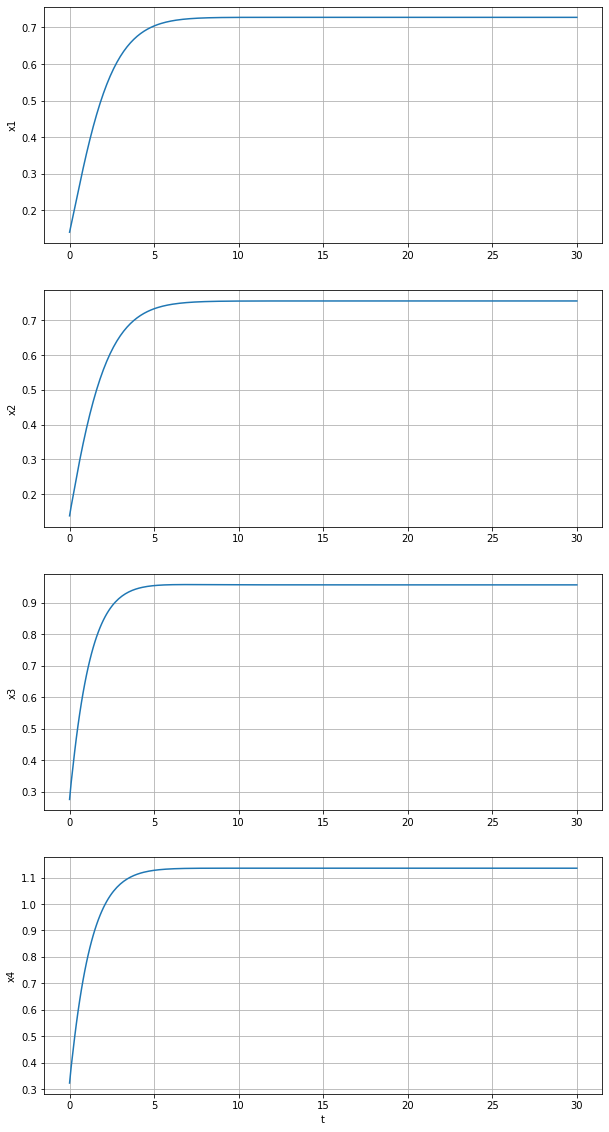

In [75]:
delta_t = dt
n = nx

x_traj = x_list

Nt = np.shape(x_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    x_traj_temp = x_traj[i::n]
    plt.plot(t_plot, x_traj_temp)
    plt.ylabel('x' + str(i + 1))

plt.xlabel('t')
plt.show()

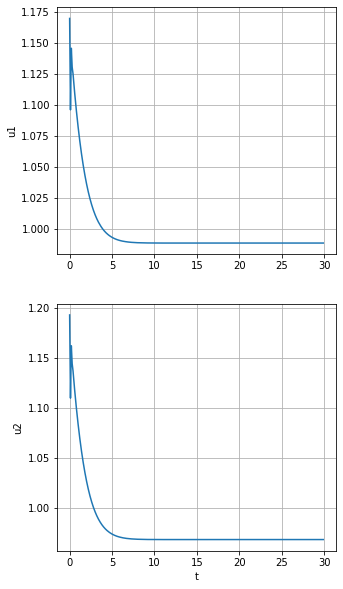

In [76]:
delta_t = dt
n = nu

u_traj = u_list

Nt = np.shape(u_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(5, 10))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    u_traj_temp = u_traj[i::n]
    plt.plot(t_plot, u_traj_temp)
    plt.ylabel('u' + str(i + 1))

plt.xlabel('t')
plt.show()